##Tiny ZipNeRF
This is a modified version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

The model uses anti-alizasing method to enhance performance

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [6]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [7]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-11-14 06:37:46--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-11-14 06:37:46--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  20.9MB/s    in 0.6s    

2024-11-14 06:37:47 (20.9 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



In [8]:
!pip install scikit-image tensorflow lpips torch

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


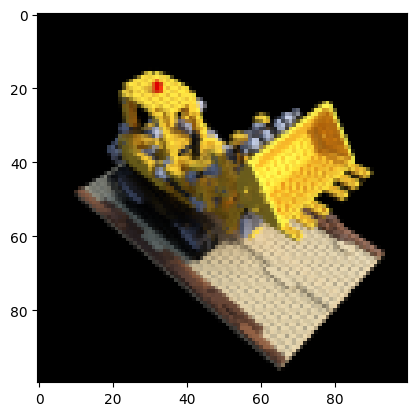

In [9]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [10]:


def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed,))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.keras.layers.Concatenate(axis=-1)([outputs, inputs])
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.14877909660339356 secs per iter


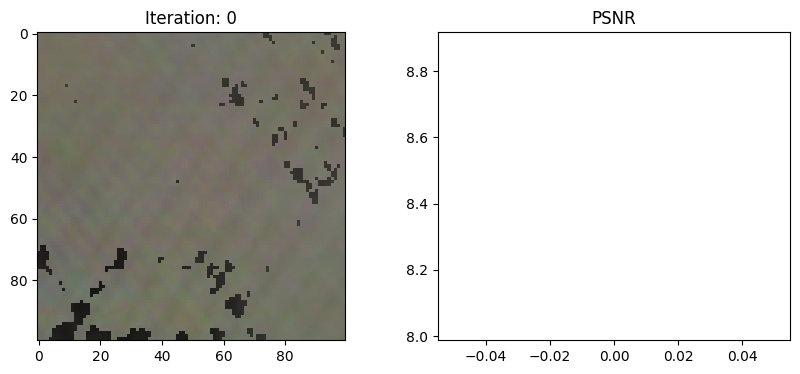

25 0.4541388988494873 secs per iter


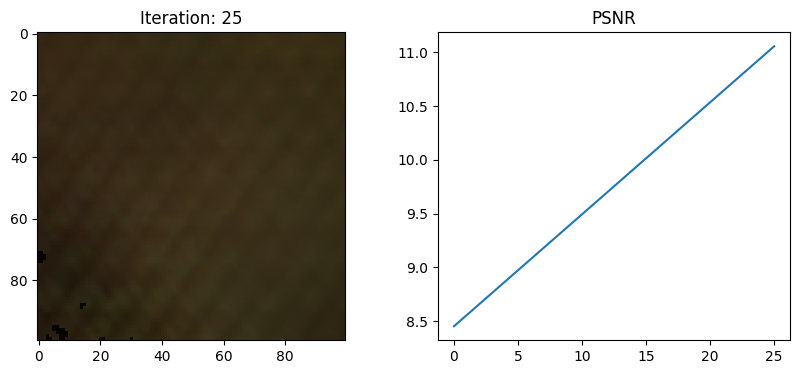

50 0.45159383773803713 secs per iter


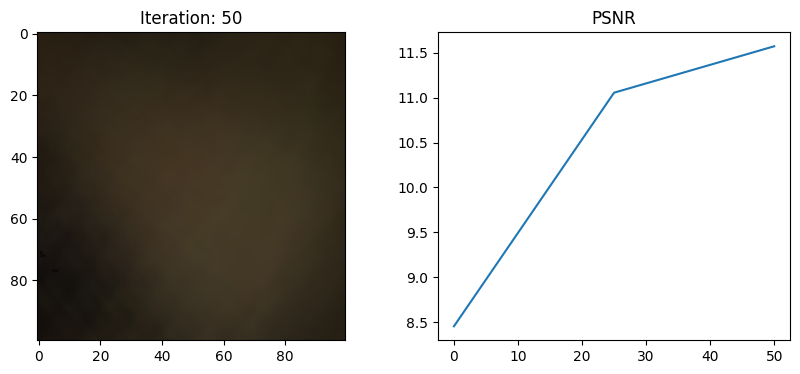

75 0.45202098846435546 secs per iter


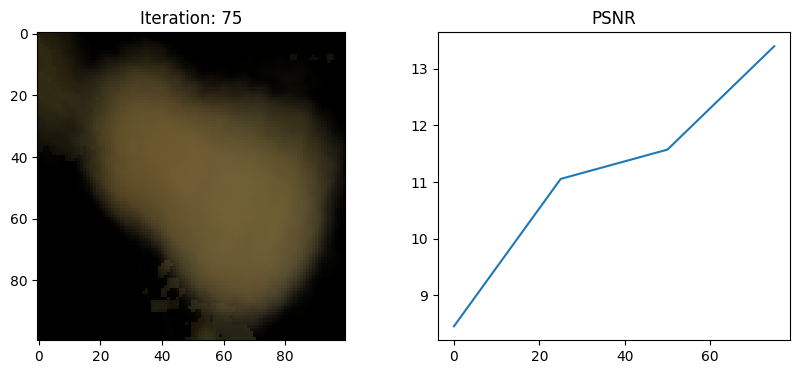

100 0.4510773181915283 secs per iter


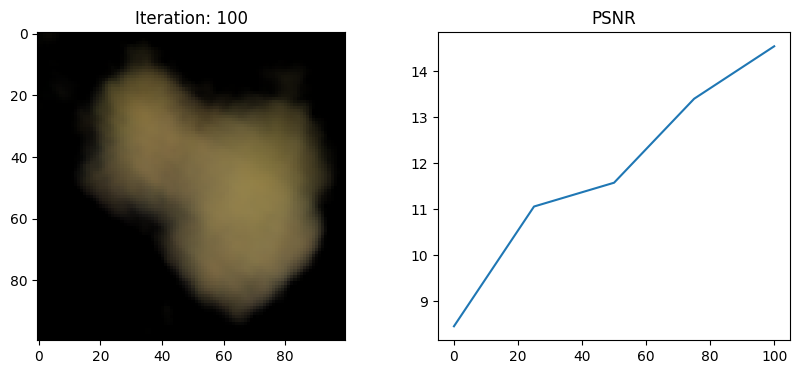

125 0.44051332473754884 secs per iter


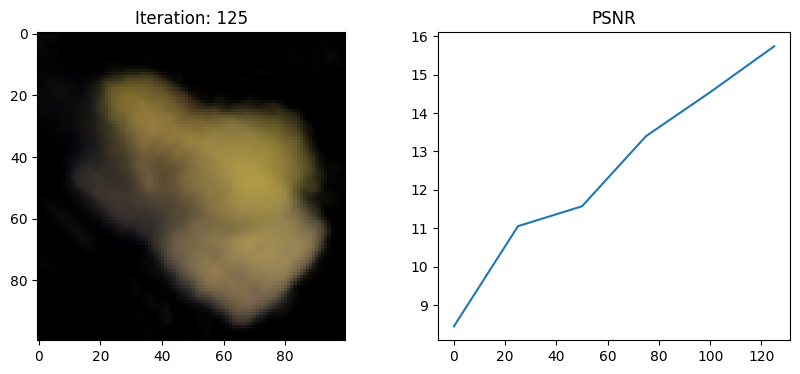

150 0.4429446315765381 secs per iter


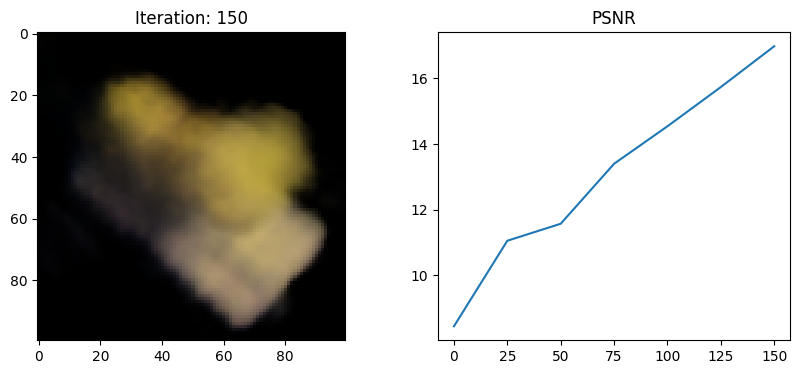

175 0.4406705188751221 secs per iter


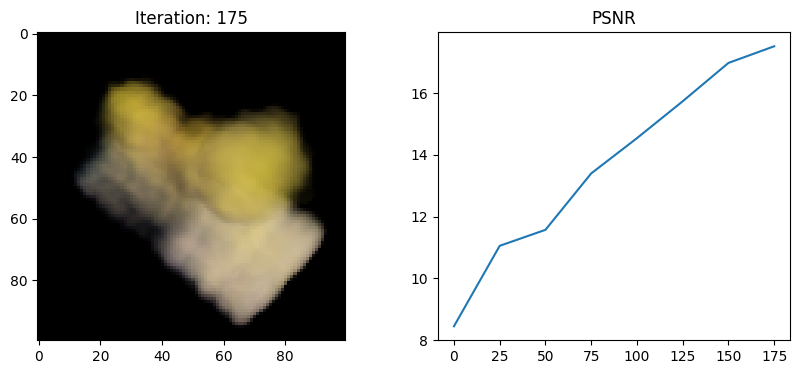

200 0.4435508060455322 secs per iter


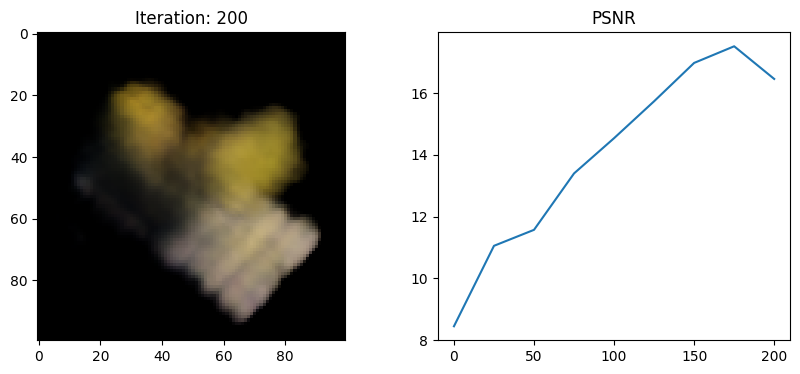

225 0.4427191162109375 secs per iter


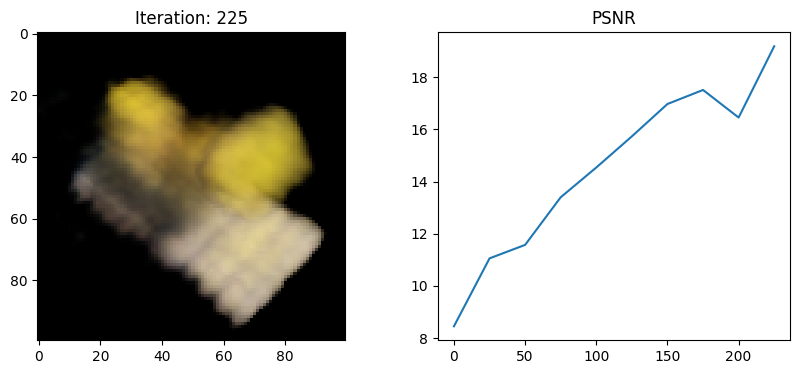

250 0.4435924816131592 secs per iter


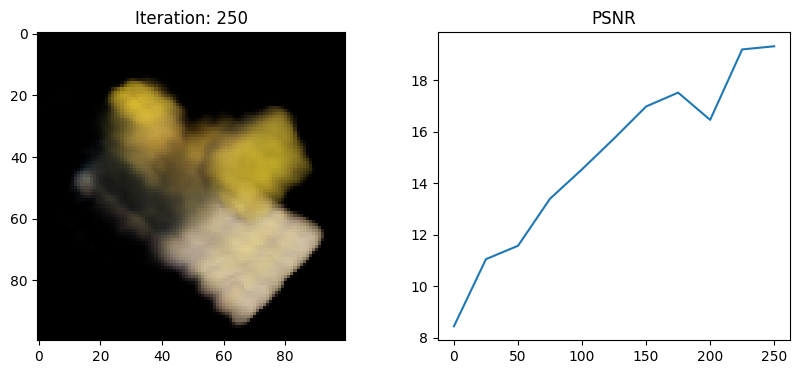

275 0.4415001964569092 secs per iter


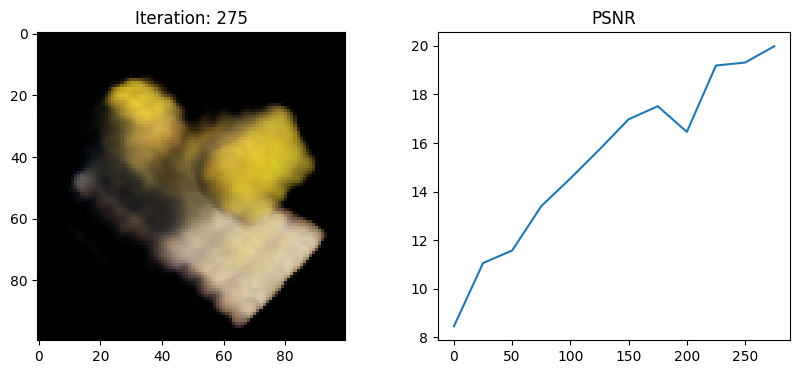

300 0.4542231559753418 secs per iter


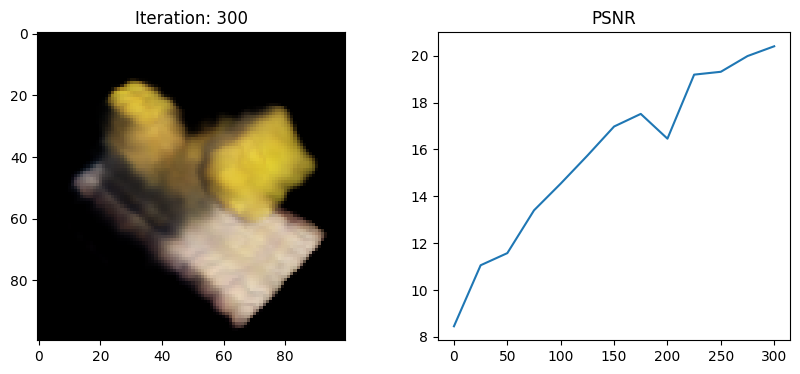

325 0.44279559135437013 secs per iter


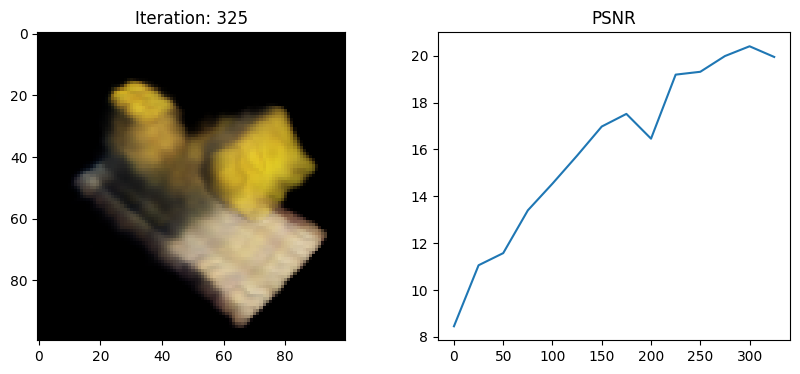

350 0.4451684284210205 secs per iter


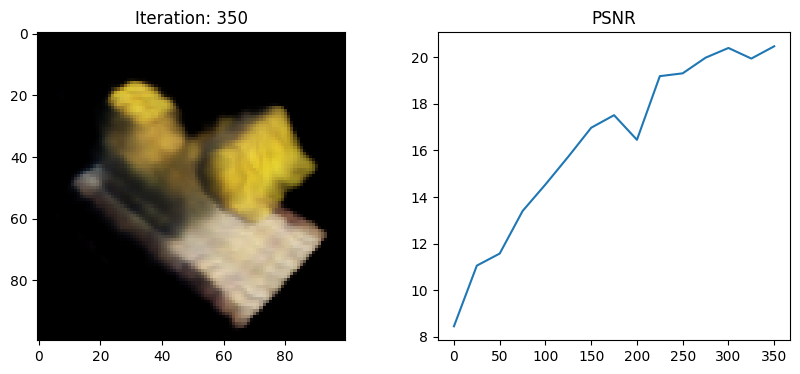

375 0.4466600227355957 secs per iter


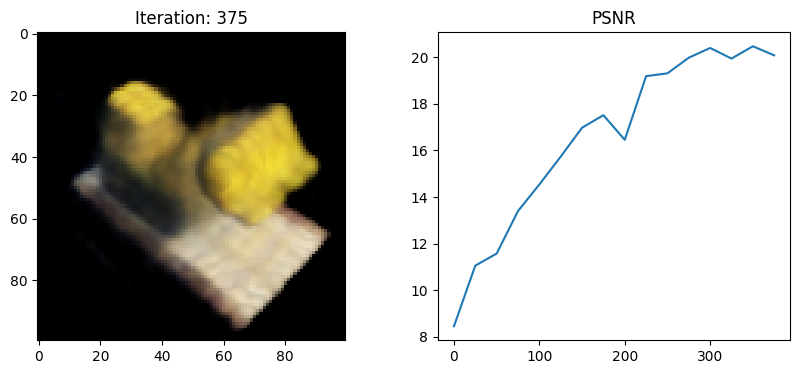

400 0.4424048137664795 secs per iter


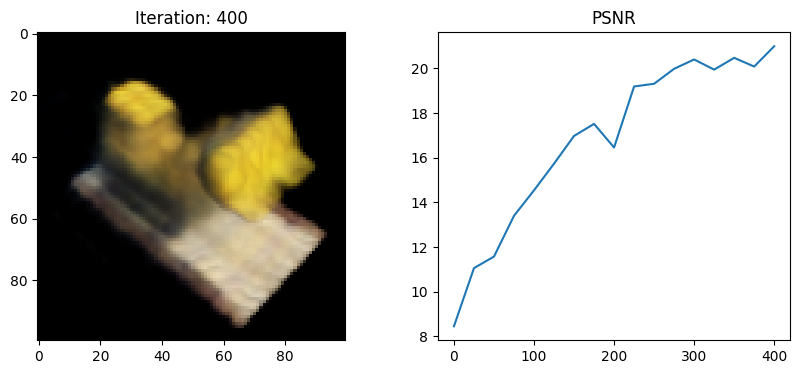

425 0.4453151321411133 secs per iter


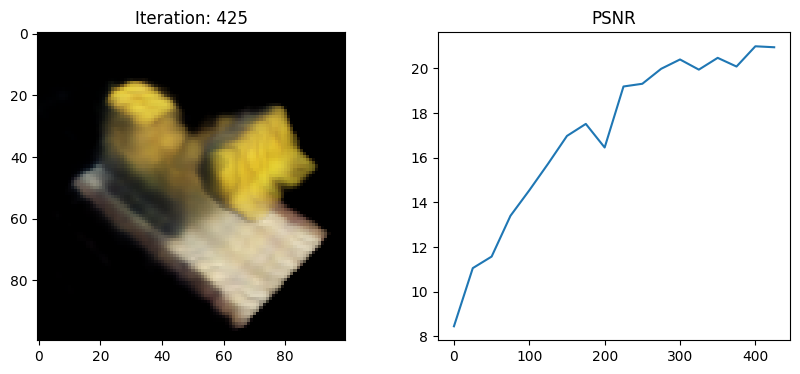

450 0.4449769496917725 secs per iter


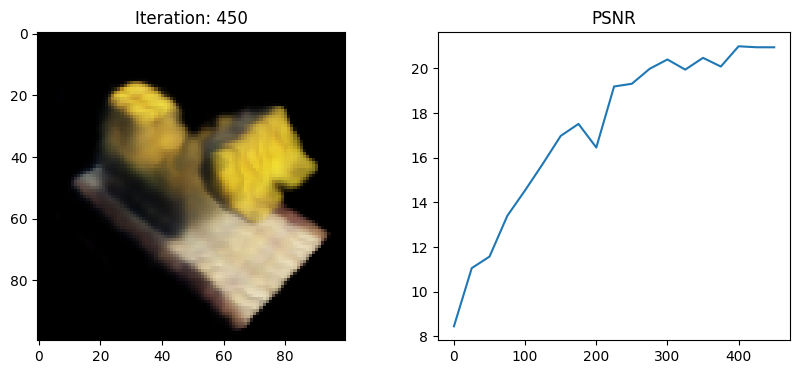

475 0.44412782669067385 secs per iter


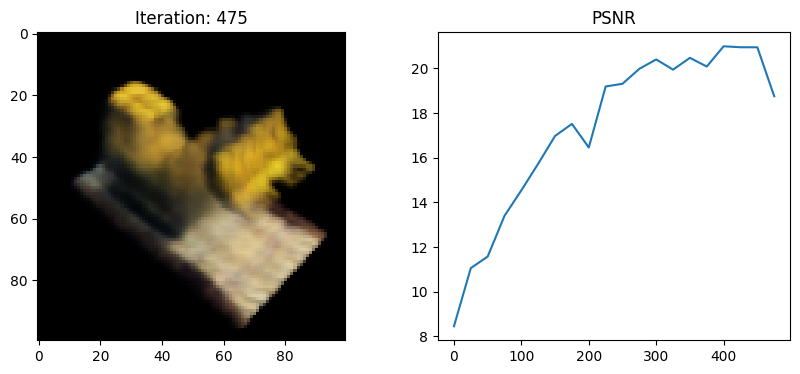

500 0.4453004837036133 secs per iter


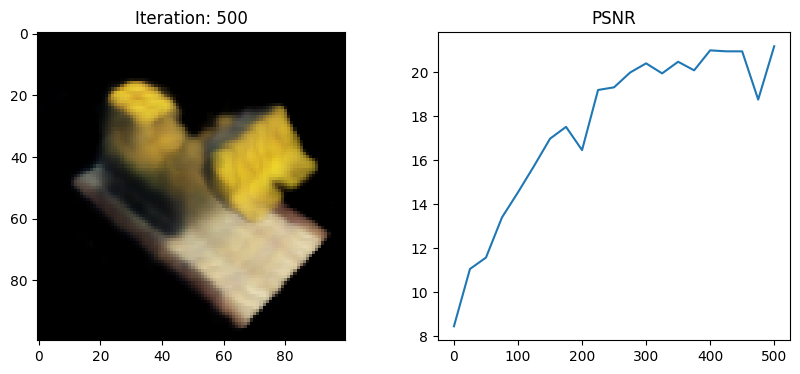

525 0.4472242450714111 secs per iter


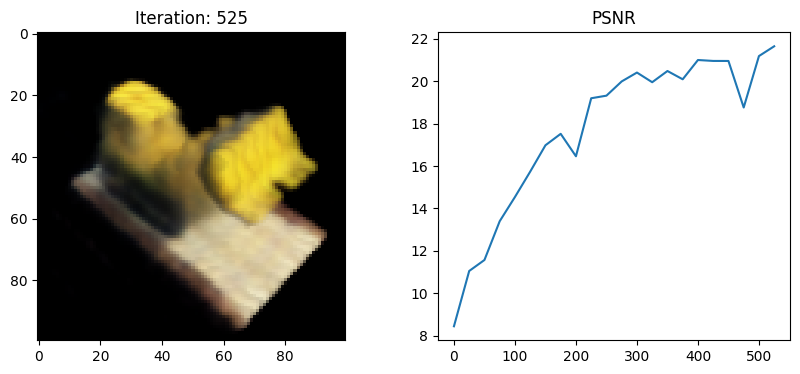

550 0.4436403560638428 secs per iter


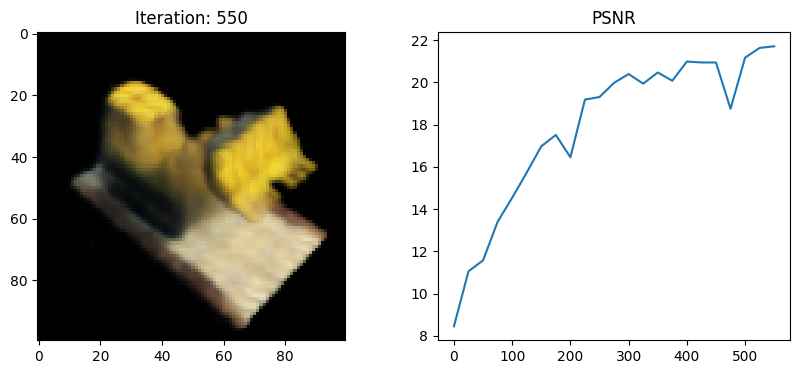

575 0.44709158897399903 secs per iter


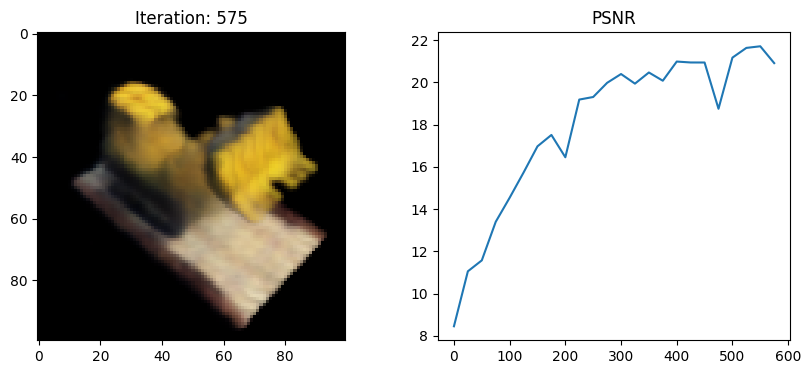

600 0.4587430572509766 secs per iter


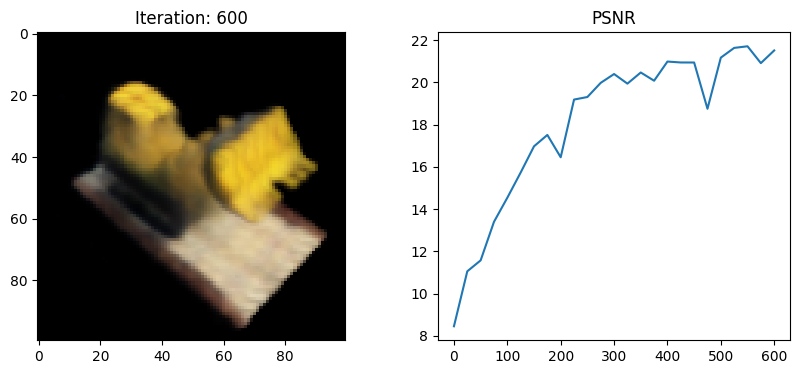

625 0.4534828472137451 secs per iter


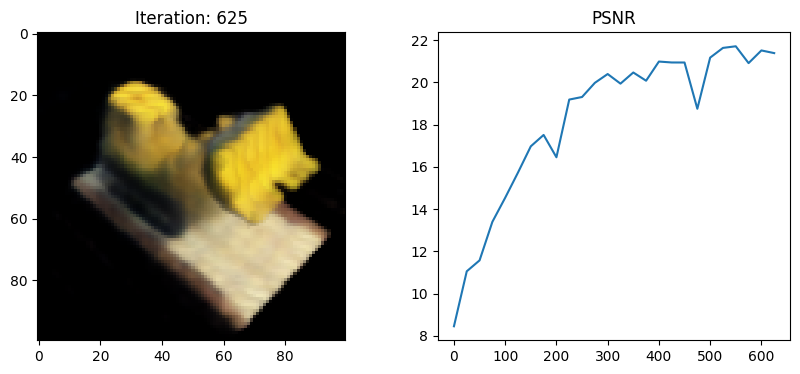

650 0.45294501304626467 secs per iter


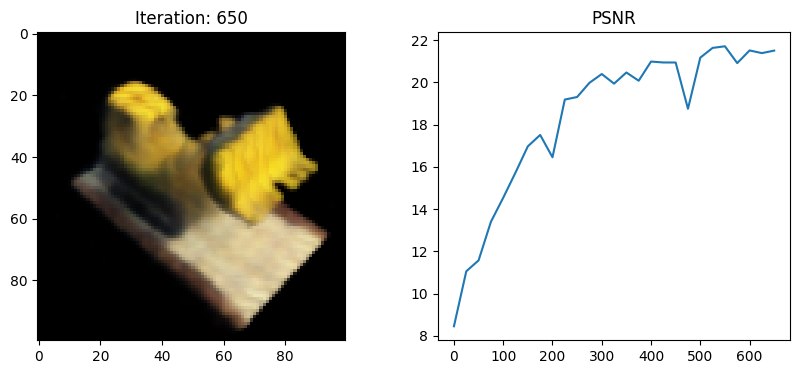

675 0.44704577445983884 secs per iter


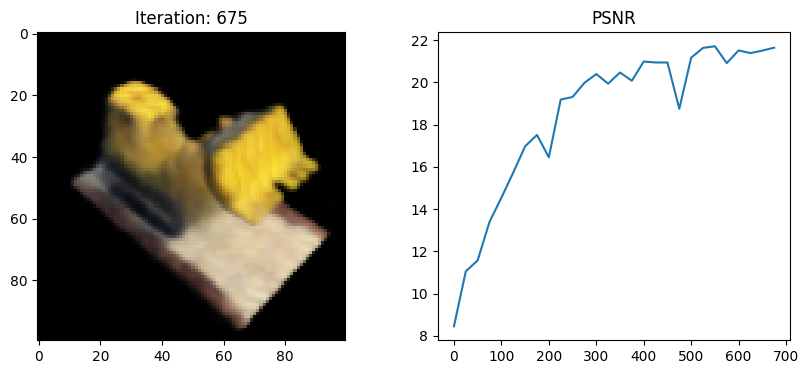

700 0.4476511192321777 secs per iter


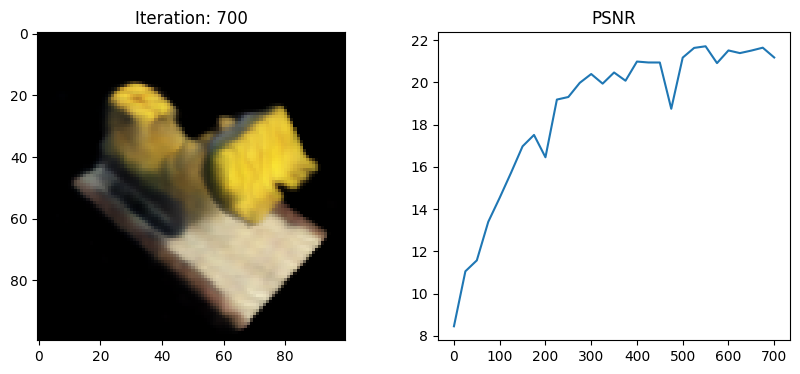

725 0.44721317291259766 secs per iter


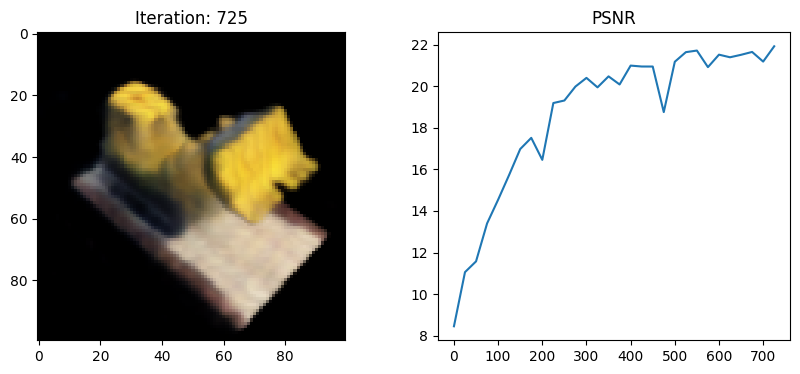

750 0.44648131370544436 secs per iter


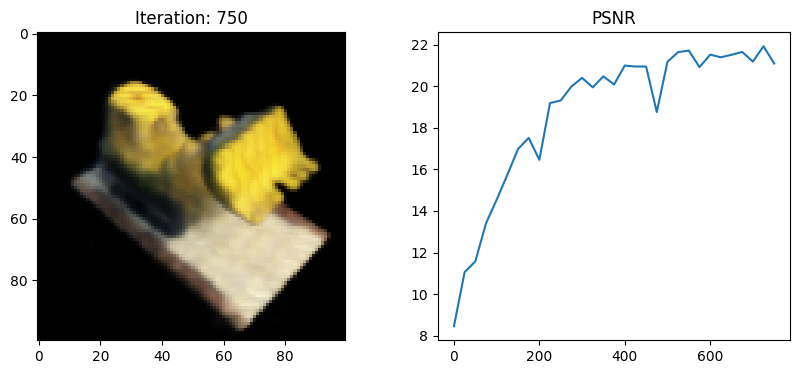

775 0.4447198963165283 secs per iter


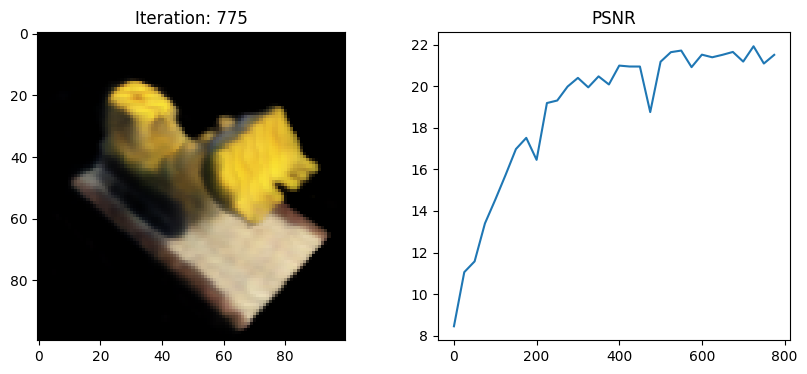

800 0.4492766284942627 secs per iter


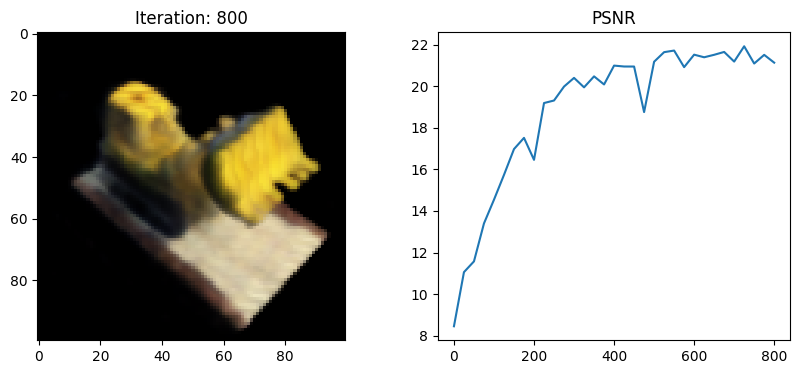

825 0.4468655776977539 secs per iter


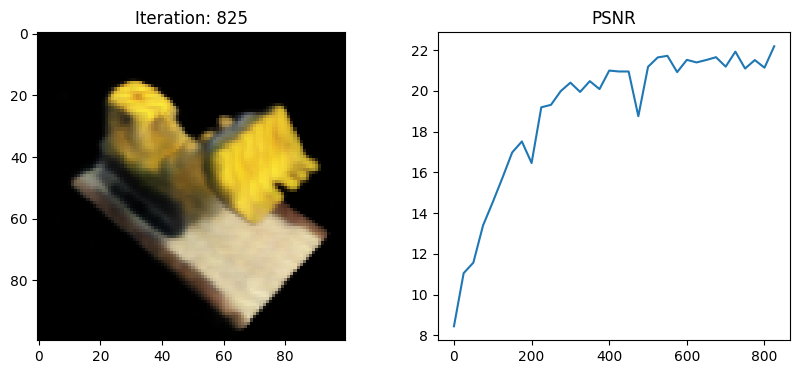

850 0.44684014320373533 secs per iter


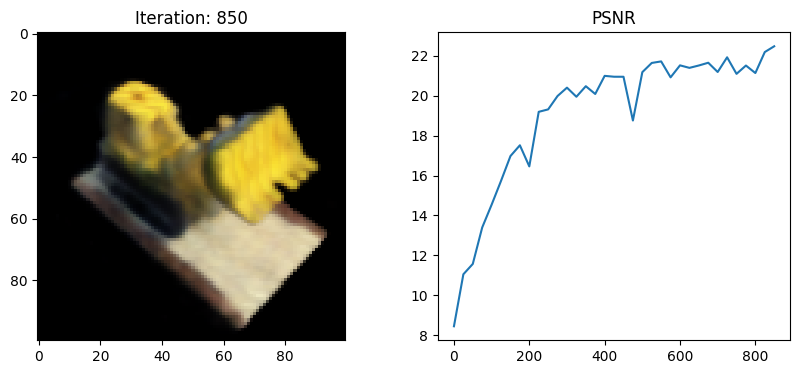

875 0.4443208312988281 secs per iter


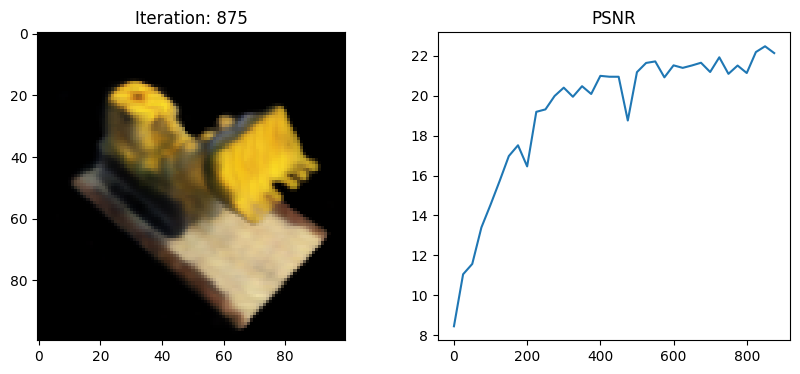

900 0.457162971496582 secs per iter


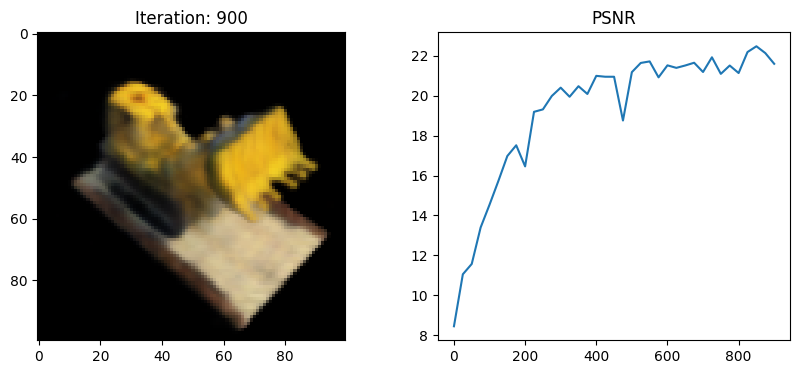

925 0.446731538772583 secs per iter


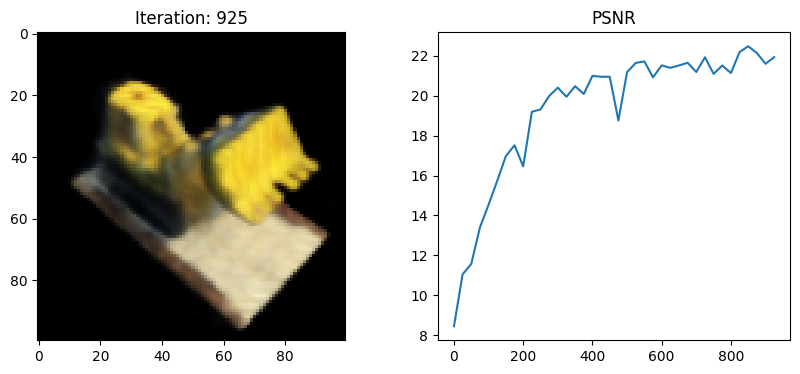

950 0.4485394763946533 secs per iter


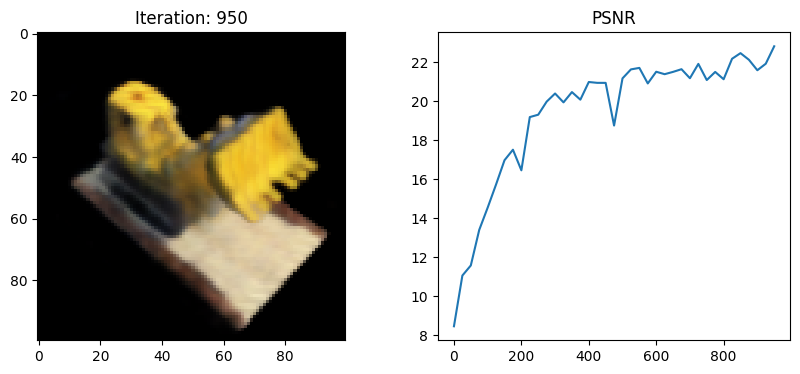

975 0.4500259208679199 secs per iter


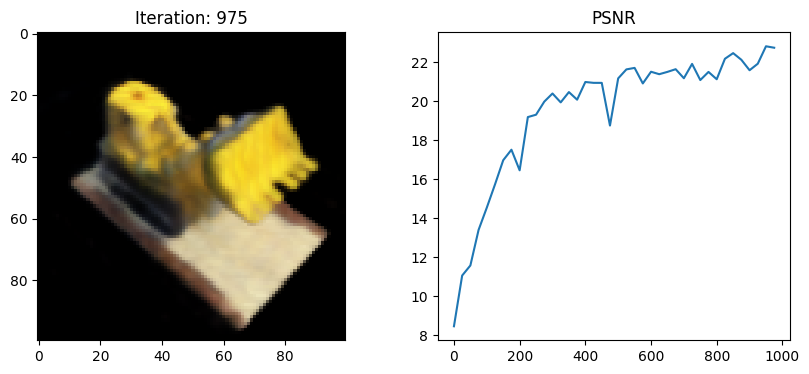

1000 0.44888814926147463 secs per iter


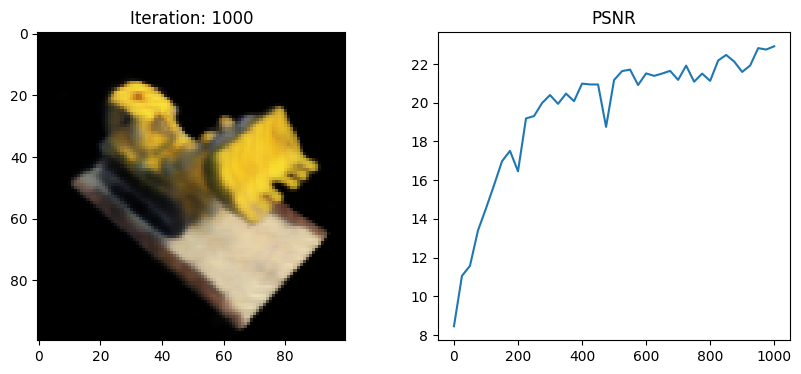

Done


In [11]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [12]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [13]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

<ipython-input-13-bc28ed268829>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [14]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Edge Detection, performance check

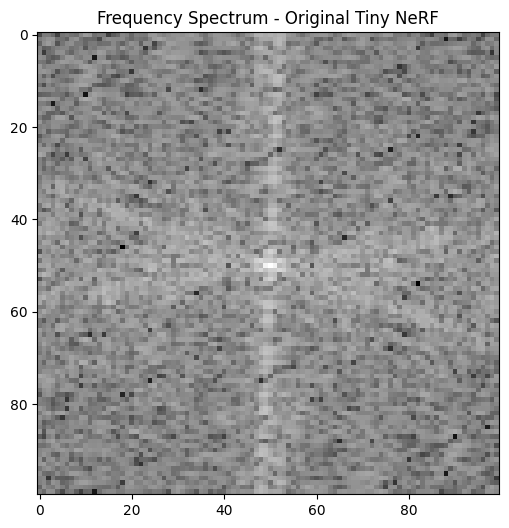

Temporal Consistency - Original Tiny NeRF: 0.0
High-Frequency Content - Original Tiny NeRF: 6.280733333333333


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Render a test image with the original Tiny NeRF model
test_image_nerf = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)[0]

# Edge Frequency Analysis
def frequency_analysis(rgb_image):
    edges = cv2.Canny((rgb_image.numpy() * 255).astype(np.uint8), 100, 200)
    f_transform = np.fft.fftshift(np.fft.fft2(edges))
    magnitude_spectrum = 20 * np.log(np.abs(f_transform) + 1)
    return magnitude_spectrum

# Calculate Frequency Spectrum for Tiny NeRF
magnitude_spectrum_nerf = frequency_analysis(test_image_nerf)
plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum_nerf, cmap='gray')
plt.title('Frequency Spectrum - Original Tiny NeRF')
plt.show()

# Temporal Consistency Calculation
def temporal_consistency(frames):
    differences = []
    for i in range(1, len(frames)):
        diff = np.mean(np.abs(frames[i] - frames[i - 1]))
        differences.append(diff)
    return np.mean(differences)

def pose_shift(pose, shift=0.1):
    new_pose = np.copy(pose)
    new_pose[:3, 3] += shift
    return new_pose

# Generate a Sequence of Frames with Slight Camera Changes
camera_poses = [pose_shift(testpose, shift=0.1 * i) for i in range(5)]
frames_nerf = [render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)[0] for pose in camera_poses]
temporal_consistency_nerf = temporal_consistency(frames_nerf)
print("Temporal Consistency - Original Tiny NeRF:", temporal_consistency_nerf)

# High-Frequency Content Analysis
def high_frequency_content(rgb_image):
    laplacian = cv2.Laplacian((rgb_image.numpy() * 255).astype(np.uint8), cv2.CV_64F)
    return np.mean(np.abs(laplacian))

hf_content_nerf = high_frequency_content(test_image_nerf)
print("High-Frequency Content - Original Tiny NeRF:", hf_content_nerf)


# PSNR, SSIM and LPIPS metrics

In [16]:
# Define `rendered_images` as the list of frames rendered by the model
rendered_images = [(255 * np.clip(rgb, 0, 1)).astype(np.uint8) for rgb, _, _ in [
    render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    for pose in poses
]]

# Define `ground_truth_images` as the ground truth images for comparison
ground_truth_images = [img for img in images[:len(rendered_images)]]

In [20]:
import tensorflow as tf
import numpy as np
from skimage.metrics import structural_similarity as ssim
import lpips
import torch

# Initialize LPIPS model for perceptual similarity
lpips_model = lpips.LPIPS(net='vgg').cuda()  # Use .cuda() if running on a GPU

# Function to compute PSNR
def compute_psnr(image1, image2):
    # Ensure both images are float32 for compatibility
    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)
    mse = tf.reduce_mean(tf.square(image1 - image2))
    psnr = 20 * tf.math.log(1.0 / tf.sqrt(mse)) / tf.math.log(10.0)
    return psnr.numpy()

# Function to compute SSIM with specified data_range and smaller win_size
def compute_ssim(image1, image2):
    return ssim(image1, image2, win_size=3, data_range=1.0, channel_axis=-1)


# Function to compute LPIPS
def compute_lpips(image1, image2):
    # Convert images to PyTorch tensors and normalize
    image1 = torch.from_numpy(image1).permute(2, 0, 1).unsqueeze(0).float().cuda()
    image2 = torch.from_numpy(image2).permute(2, 0, 1).unsqueeze(0).float().cuda()
    lpips_score = lpips_model(image1, image2)
    return lpips_score.item()

# Lists to store the results
psnr_scores = []
ssim_scores = []
lpips_scores = []

# Iterate over each rendered and ground truth image pair
for rendered_img, gt_img in zip(rendered_images, ground_truth_images):
    # Ensure images are scaled to [0, 1] range if they are not already
    rendered_img = np.clip(rendered_img / 255.0, 0, 1).astype(np.float32)
    gt_img = np.clip(gt_img / 255.0, 0, 1).astype(np.float32)

    # Compute PSNR
    psnr_score = compute_psnr(rendered_img, gt_img)
    psnr_scores.append(psnr_score)

    # Compute SSIM
    ssim_score = compute_ssim(rendered_img, gt_img)
    ssim_scores.append(ssim_score)

    # Compute LPIPS
    lpips_score = compute_lpips(rendered_img, gt_img)
    lpips_scores.append(lpips_score)

# Calculate average scores for each metric
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)
avg_lpips = np.mean(lpips_scores)

# Print results
print("Performance Metrics for Tiny NeRF Model:")
print(f"Average PSNR: {avg_psnr}")
print(f"Average SSIM: {avg_ssim}")
print(f"Average LPIPS: {avg_lpips}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth
Performance Metrics for Tiny NeRF Model:
Average PSNR: 13.474038124084473
Average SSIM: 0.639725923538208
Average LPIPS: 0.44768621534109115
